In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris

iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target

dataset_shape = df.shape  
num_features = df.drop(columns=['target']).shape[1] 
class_counts = df['target'].value_counts()  
num_classes = len(class_counts)  

missing_values = df.isna().sum()
missing_percentage = (missing_values / len(df)) * 100  

print("Размерность датасета:", dataset_shape)
print("Количество признаков:", num_features)
print("Количество классов:", num_classes)
print("Объекты в каждом классе:")
print(class_counts)
print("\nПроцент пропущенных значений:")
print(missing_percentage)

selected_classes = [0, 1, 2]  
selected_features = iris.feature_names[:4]  

filtered_df = df.dropna(subset=selected_features)

print(filtered_df)


Размерность датасета: (150, 5)
Количество признаков: 4
Количество классов: 3
Объекты в каждом классе:
target
0    50
1    50
2    50
Name: count, dtype: int64

Процент пропущенных значений:
sepal length (cm)    0.0
sepal width (cm)     0.0
petal length (cm)    0.0
petal width (cm)     0.0
target               0.0
dtype: float64
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3

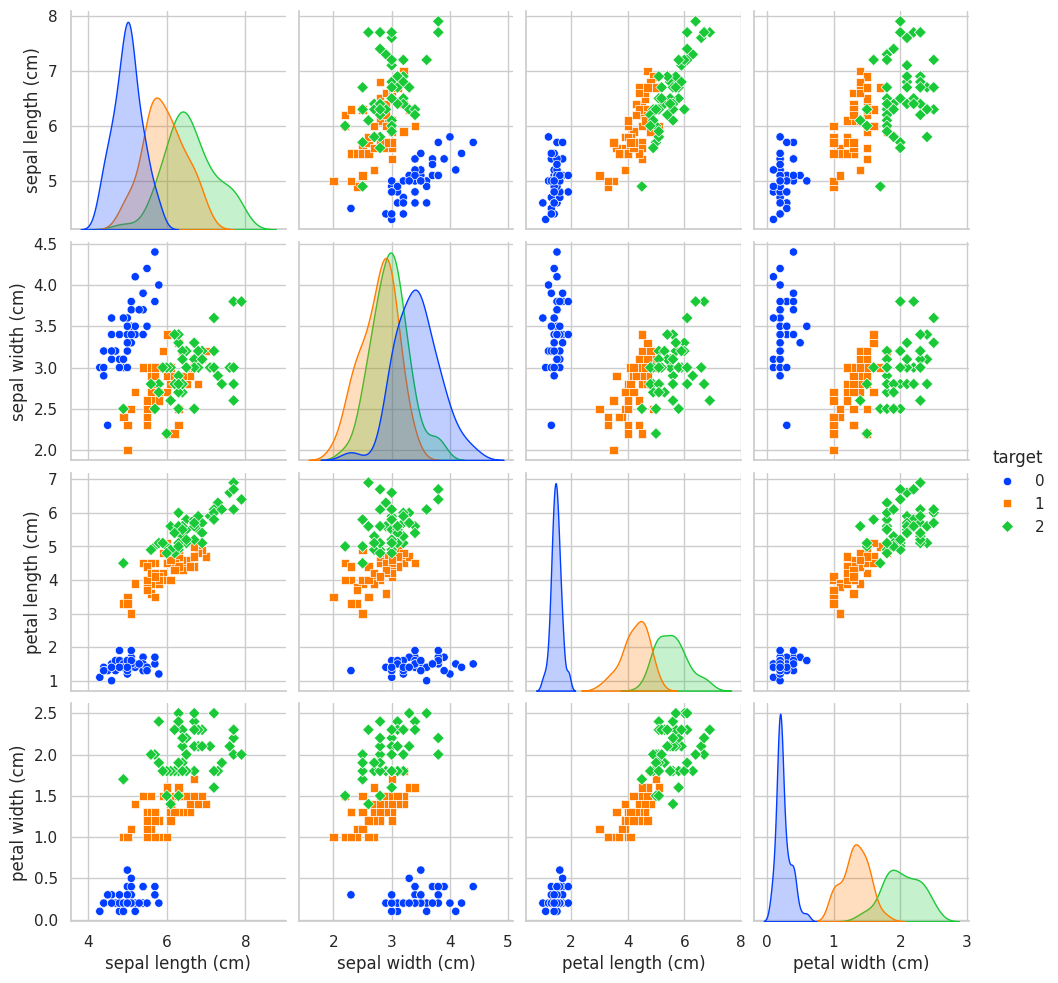

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target

sns.set(style="whitegrid")

pair_plot = sns.pairplot(df, hue='target', palette='bright', markers=["o", "s", "D"], diag_kind='kde')

plt.show()


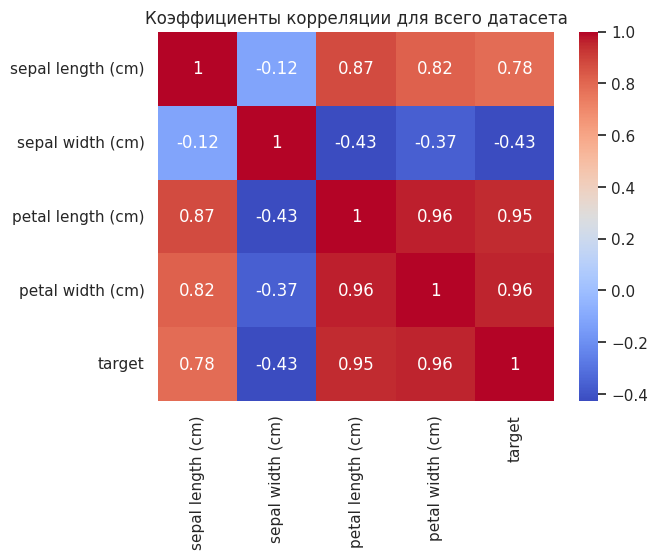

In [3]:
correlation_matrix = df.corr(method='pearson')

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Коэффициенты корреляции для всего датасета')
plt.show()

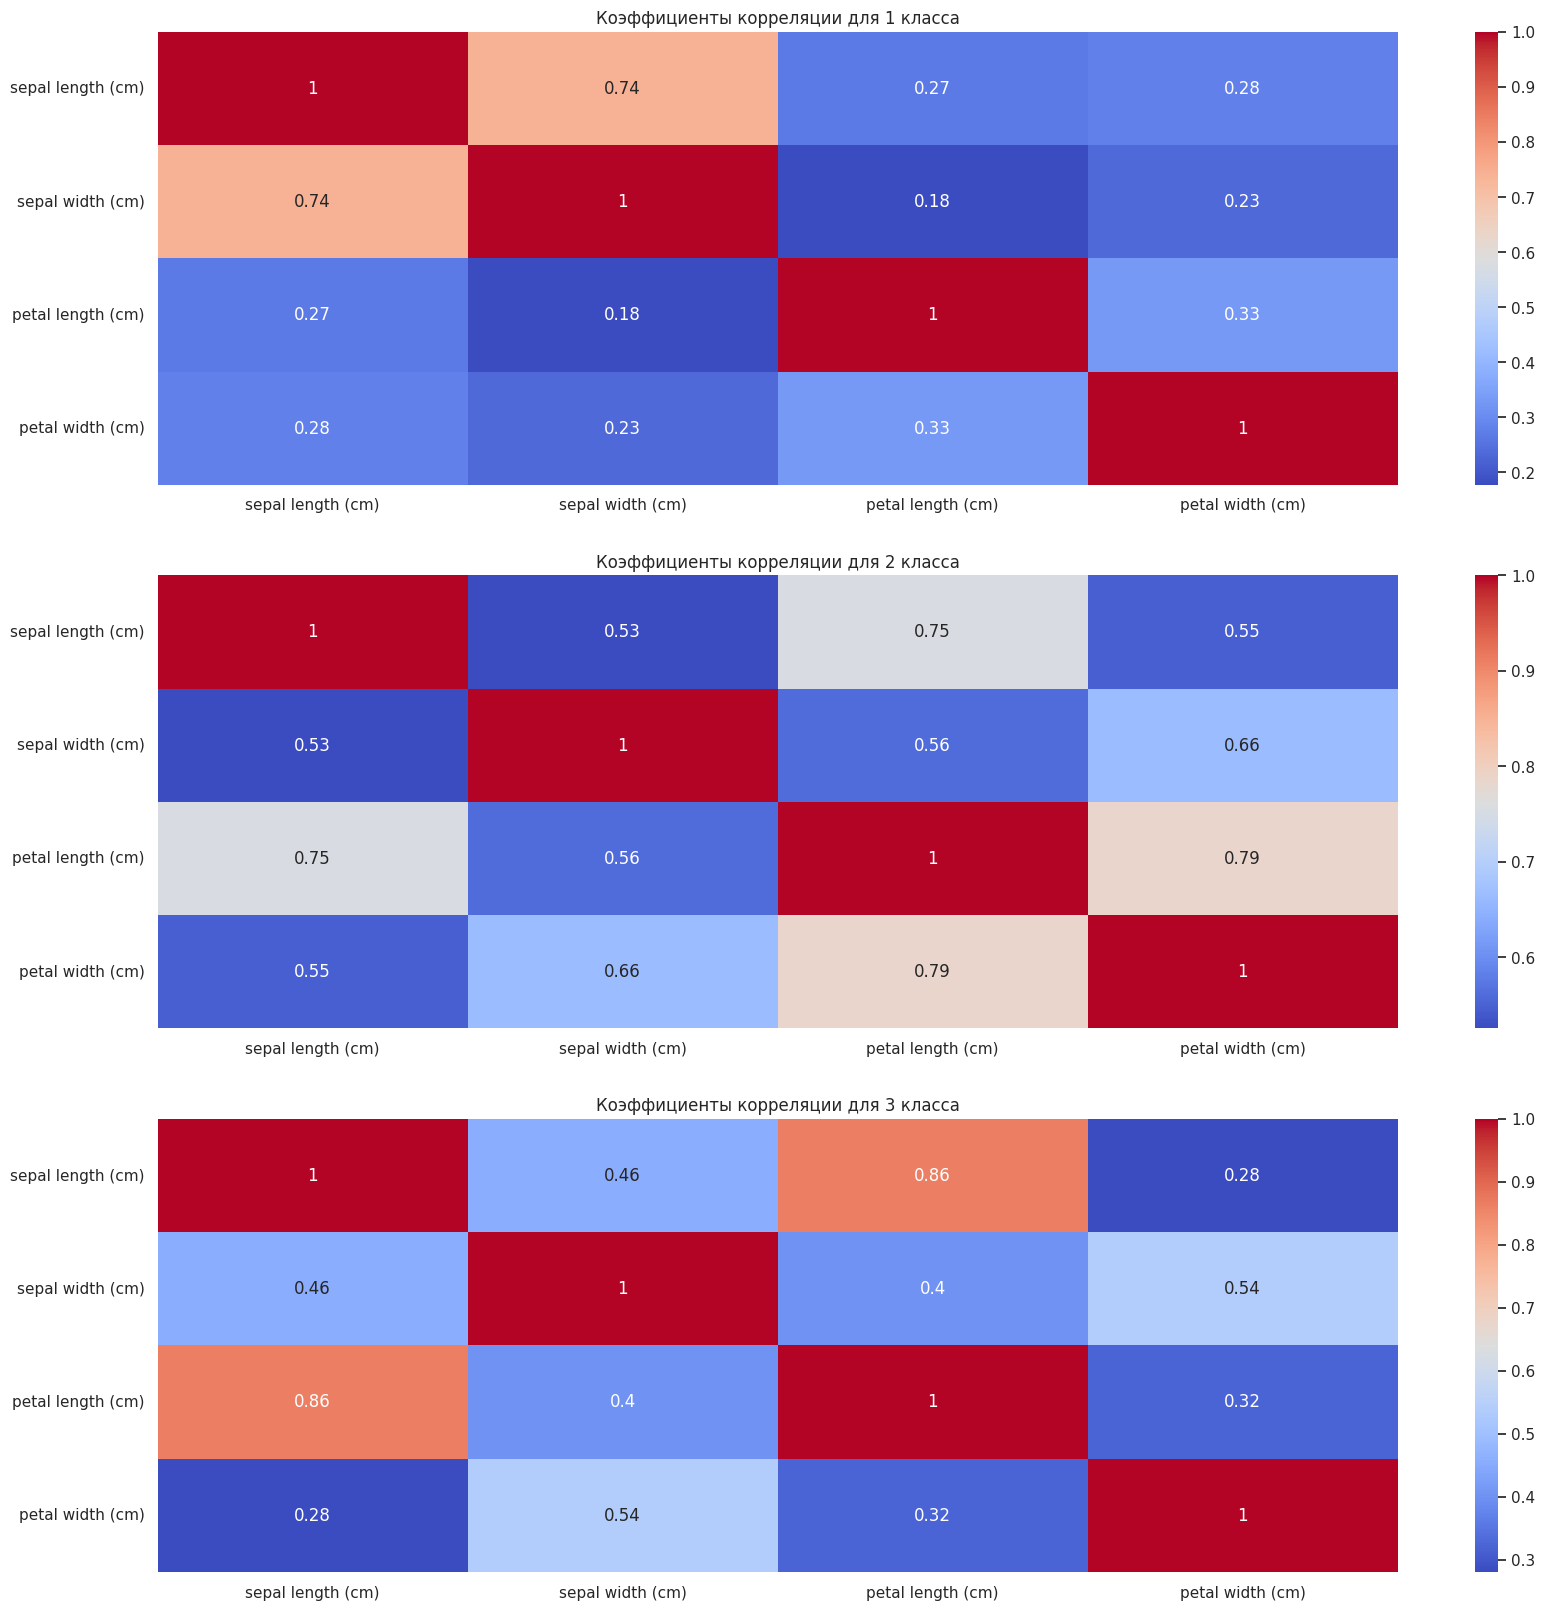

In [4]:
def get_corr_for_target(df, target_id):
    df_out = df[df['target'] == target_id]
    df_out = df_out.drop(columns=['target'])
    return df_out.corr(method='pearson')

plt.figure(figsize=(20, 20))

for i in range(num_classes):
    corr_mat_i = get_corr_for_target(df, i)
    plt.subplot(num_classes, 1, i + 1)
    sns.heatmap(corr_mat_i, annot=True, cmap='coolwarm')
    plt.title(f'Коэффициенты корреляции для {i + 1} класса')

plt.show()

In [5]:
from scipy.linalg import eigh

class LDA:
    def __init__(self, n_components=None):
        self.n_components = n_components

    def fit(self, X, y):
        n_samples, n_features = X.shape
        classes, cls_counts = np.unique(y, return_counts=True)
        priors = cls_counts / n_samples

        X_cls_mean = np.array([X[y == cls].mean(axis=0) for cls in classes])
        between_cls_deviation = X_cls_mean - X.mean(axis=0)
        within_cls_deviation = X - X_cls_mean[y]

        Sb = priors * between_cls_deviation.T @ between_cls_deviation
        Sw = within_cls_deviation.T @ within_cls_deviation / n_samples
        evals, evecs = eigh(Sb, Sw)
        self.dvecs = evecs[:, np.argsort(evals)[::-1]] 

        self.weights = X_cls_mean @ self.dvecs @ self.dvecs.T
        self.bias = np.log(priors) - 0.5 * np.diag(X_cls_mean @ self.weights.T)

        if self.n_components is None:
            self.n_components = min(classes.size - 1, n_features)

    def transform(self, X):
        return X @ self.dvecs[:, : self.n_components]

    def predict(self, X_test):
        scores = X_test @ self.weights.T + self.bias

        return np.argmax(scores, axis=1)
    
    def predict_proba(self, X_test):
        scores = X_test @ self.weights.T + self.bias
        exp_scores = np.exp(scores)
        probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        return probabilities

    
lda = LDA()

target = df.target
features = df.drop(columns=['target']).values

lda.fit(features, target)
lda_pred_res = lda.predict(features)


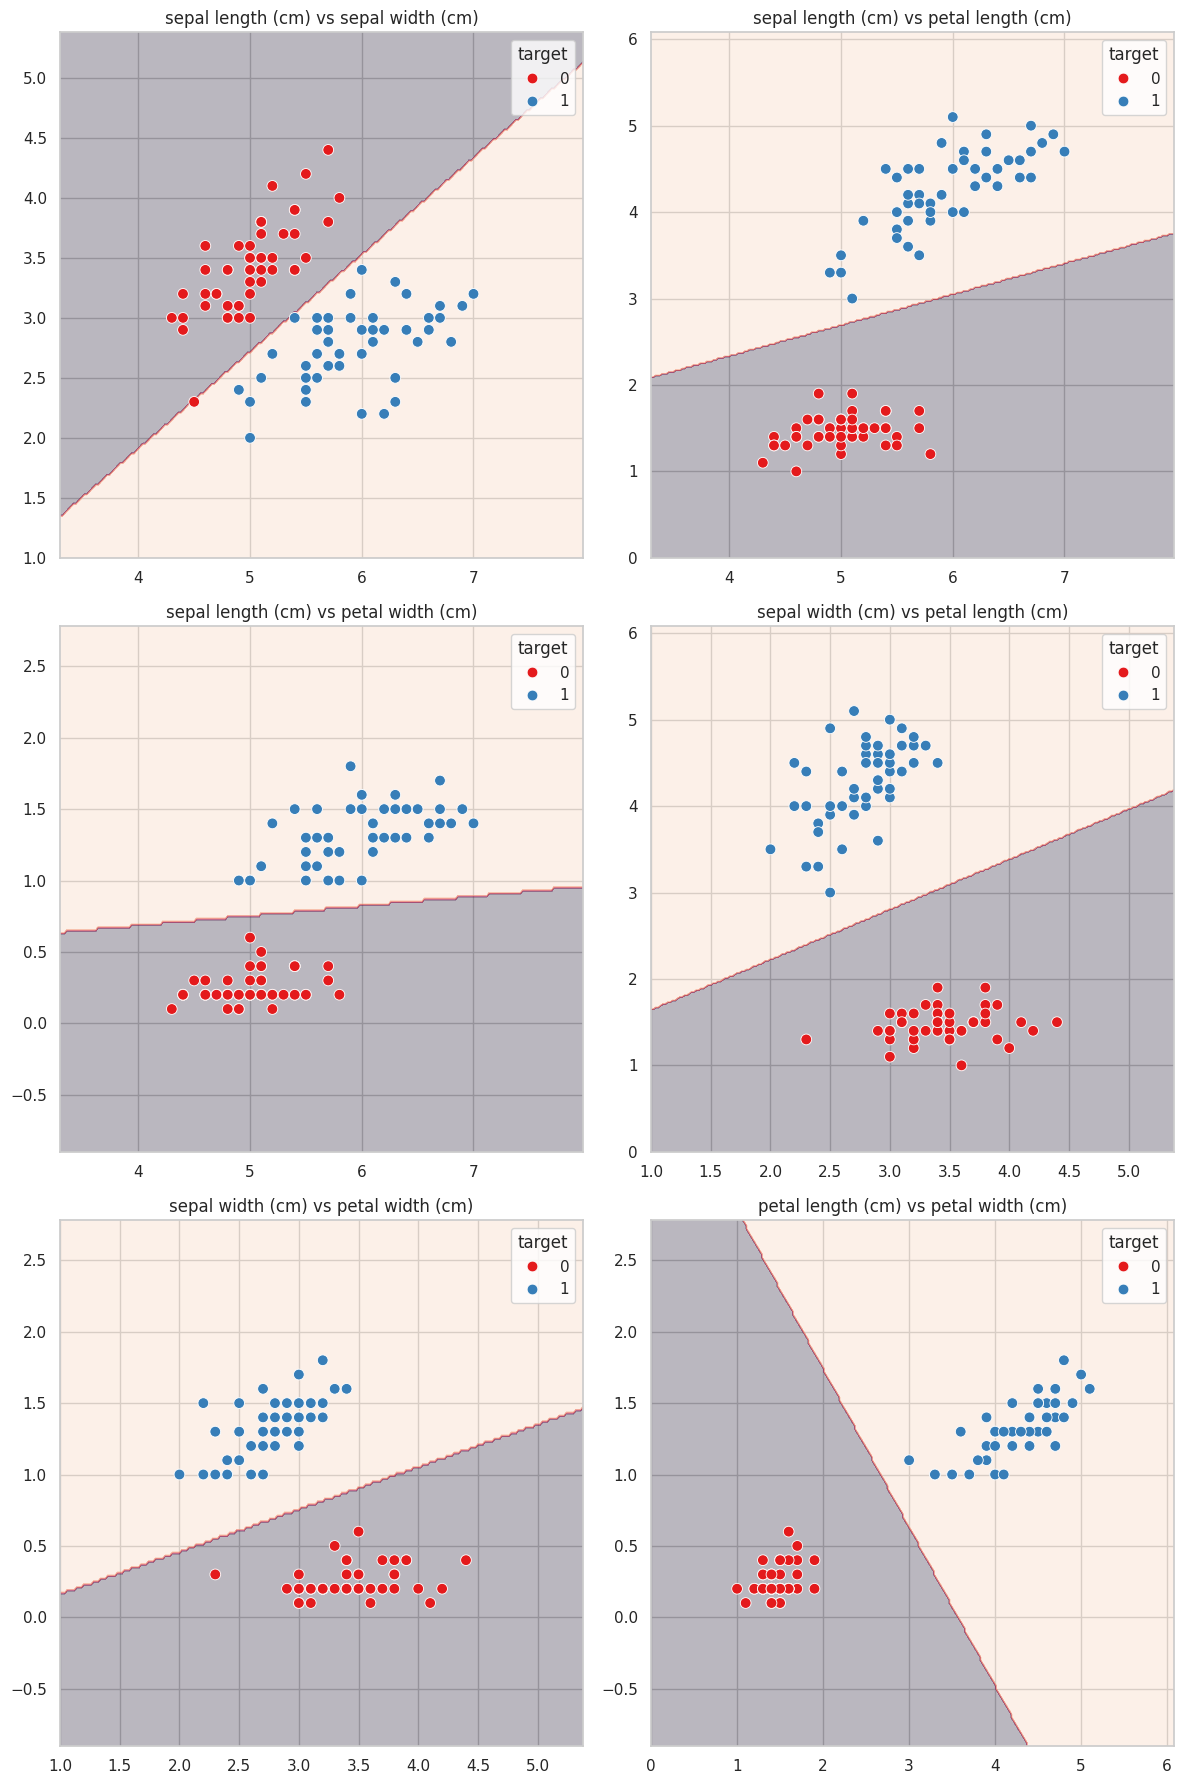

In [6]:
X_selected = features[target != 2]
y_selected = target[target != 2]

feature_names = df.columns.to_list()

lda = LDA()

def plot_lda_on_feature_pairs(X, y, lda, feature_names):
    _, axes = plt.subplots(3, 2, figsize=(12, 18))
    pair_indices = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
    
    for i, (x_idx, y_idx) in enumerate(pair_indices):
        ax = axes.flat[i]
        lda.fit(X[:, [x_idx, y_idx]], y)
        
        x_min, x_max = X[:, x_idx].min() - 1, X[:, x_idx].max() + 1
        y_min, y_max = X[:, y_idx].min() - 1, X[:, y_idx].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))
        
        Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(yy.shape)
        
        ax.contourf(xx, yy, Z, alpha=0.3)
        sns.scatterplot(x=X[:, x_idx], y=X[:, y_idx], hue=y, ax=ax, palette='Set1', s=60)
        ax.set_title(f'{feature_names[x_idx]} vs {feature_names[y_idx]}')

    plt.tight_layout()
    plt.show()

plot_lda_on_feature_pairs(X_selected, y_selected, lda, feature_names)


In [7]:
class LogisticRegression():
    def __init__(self, feature_size, epochs=1000, lr=1e-3):
        self.W = np.random.normal(0, 0.01, feature_size)
        self.b = 0
        self.epochs = epochs
        self.lr = lr

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def _loss_func(self, y, target):
        return -np.mean(target * np.log(y) + (1 - target) * np.log(1 - y))
    
    def fit(self, X, target):
        for _ in range(self.epochs):
            linear_model = X @ self.W + self.b
            y = self._sigmoid(linear_model)
            gradient = y - target
            
            self.W -= self.lr * (X.T @ gradient) / X.shape[0]
            self.b -= self.lr * np.mean(gradient)

    def predict(self, X):
        return np.round(self._sigmoid(X @ self.W + self.b))
    
    def predict_proba(self, X):
        proba_class_1 = self._sigmoid(X @ self.W + self.b)
        proba_class_0 = 1 - proba_class_1
        return np.column_stack((proba_class_0, proba_class_1))


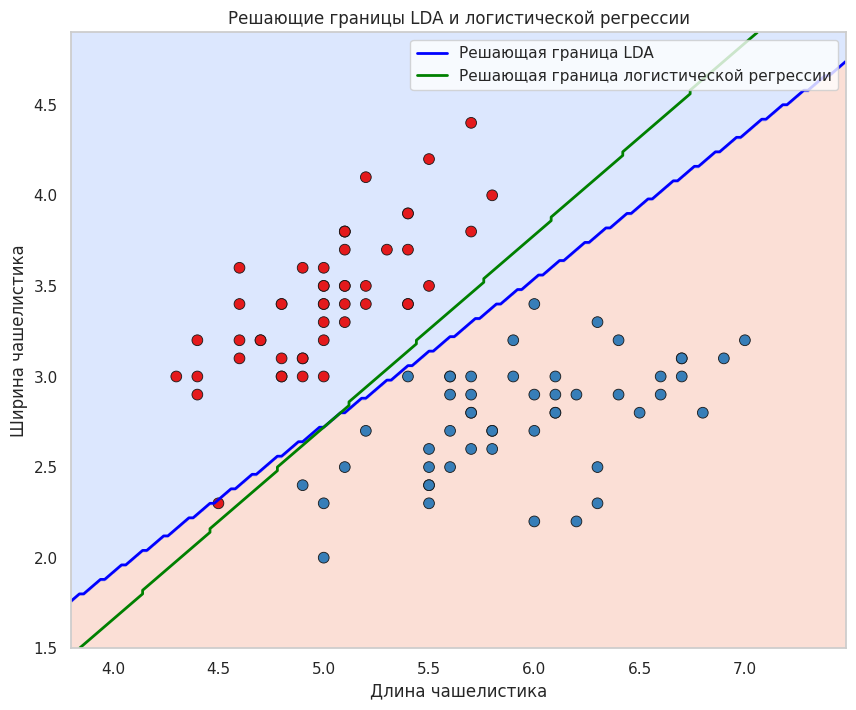

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from matplotlib.lines import Line2D

iris = datasets.load_iris()
X = iris.data[:, :2]  
y = iris.target

class_1 = 0 
class_2 = 1 
mask = np.isin(y, [class_1, class_2]) 
X_selected = X[mask]
y_selected = y[mask]

lda = LDA()
lda.fit(X_selected, y_selected)

log_reg = LogisticRegression(X_selected.shape[1], epochs=10**5, lr=1)
log_reg.fit(X_selected, y_selected)

x_min, x_max = X_selected[:, 0].min() - 0.5, X_selected[:, 0].max() + 0.5
y_min, y_max = X_selected[:, 1].min() - 0.5, X_selected[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z_lda = lda.predict(np.c_[xx.ravel(), yy.ravel()])
Z_lda = Z_lda.reshape(xx.shape)

Z_logreg = log_reg.predict(np.c_[xx.ravel(), yy.ravel()])
Z_logreg = Z_logreg.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z_lda, alpha=0.3, cmap='coolwarm', levels=np.arange(-0.5, 2, 1))
plt.contour(xx, yy, Z_lda, colors='blue', levels=[0], linewidths=2)

plt.contour(xx, yy, Z_logreg, colors='green', levels=[0], linewidths=2)

sns.scatterplot(x=X_selected[:, 0], y=X_selected[:, 1], hue=y_selected, palette='Set1', s=60, edgecolor='k')

plt.title('Решающие границы LDA и логистической регрессии')
plt.xlabel('Длина чашелистика')
plt.ylabel('Ширина чашелистика')
legend_elements = [Line2D([0], [0], color='blue', lw=2, label='Решающая граница LDA'),
                   Line2D([0], [0], color='green', lw=2, label='Решающая граница логистической регрессии')]
plt.legend(handles=legend_elements, loc='upper right')
plt.grid()
plt.show()


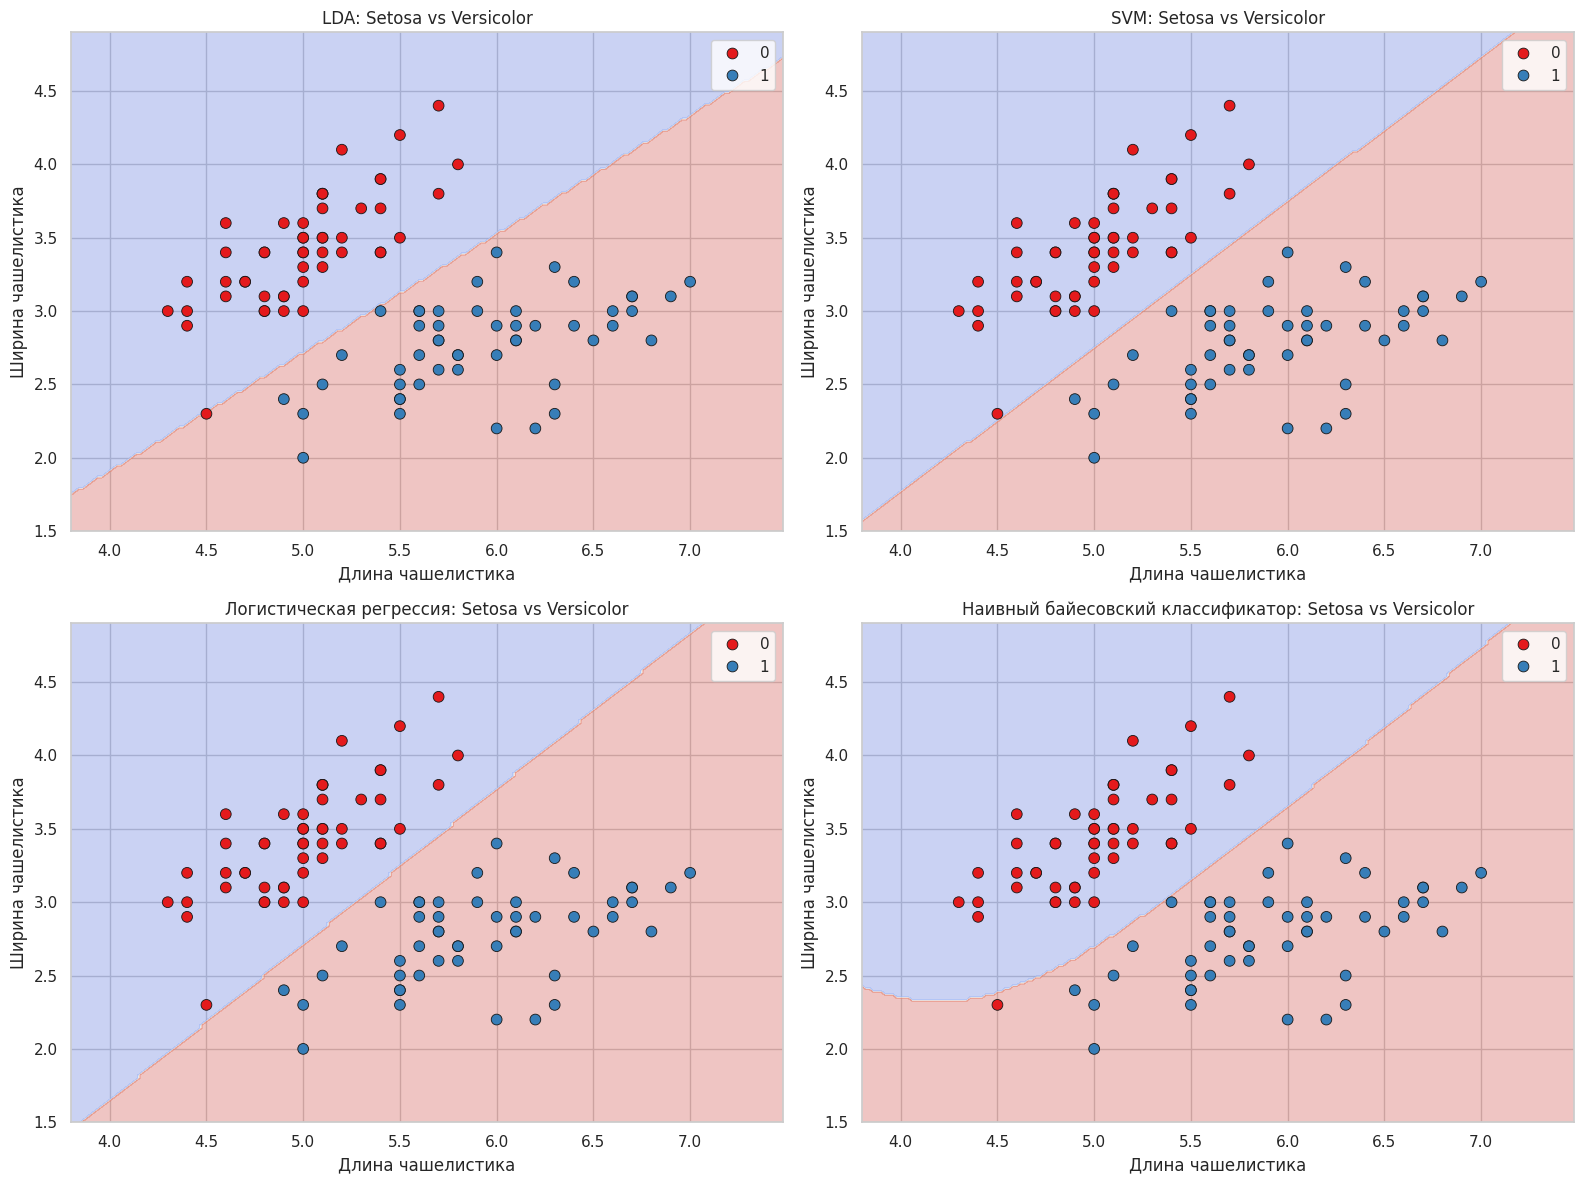

In [9]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

def plot_decision_boundary(clf, X, y, title, ax):
    clf.fit(X, y)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='Set1', s=60, edgecolor='k', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Длина чашелистика')
    ax.set_ylabel('Ширина чашелистика')

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

lda_clf = LDA()
plot_decision_boundary(lda_clf, X_selected, y_selected, title='LDA: Setosa vs Versicolor', ax=axes[0, 0])

svm_clf = SVC(kernel='linear', probability=True)
plot_decision_boundary(svm_clf, X_selected, y_selected, title='SVM: Setosa vs Versicolor', ax=axes[0, 1])

logreg_clf = LogisticRegression(X_selected.shape[1], epochs=10**5, lr=1)
plot_decision_boundary(logreg_clf, X_selected, y_selected, title='Логистическая регрессия: Setosa vs Versicolor', ax=axes[1, 0])

nb_clf = GaussianNB()
plot_decision_boundary(nb_clf, X_selected, y_selected, title='Наивный байесовский классификатор: Setosa vs Versicolor', ax=axes[1, 1])

plt.tight_layout()
plt.show()


LDA - Матрица ошибок:
[[49  1]
 [ 0 50]]
LDA - Sensitivity: 1.00
LDA - Specificity: 0.98
LDA - Precision: 0.98
LDA - Recall: 1.00


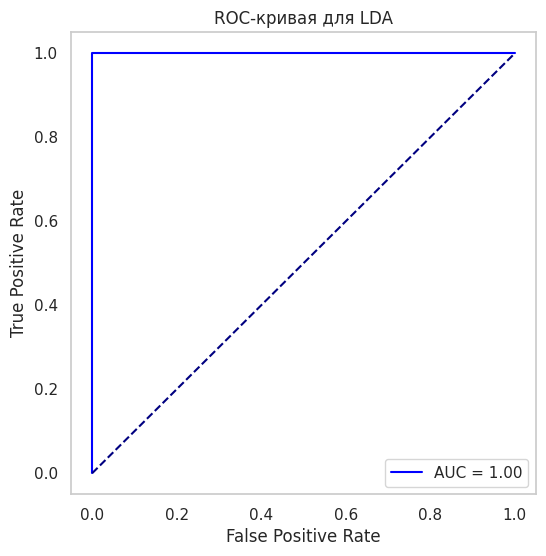

SVM - Матрица ошибок:
[[50  0]
 [ 0 50]]
SVM - Sensitivity: 1.00
SVM - Specificity: 1.00
SVM - Precision: 1.00
SVM - Recall: 1.00


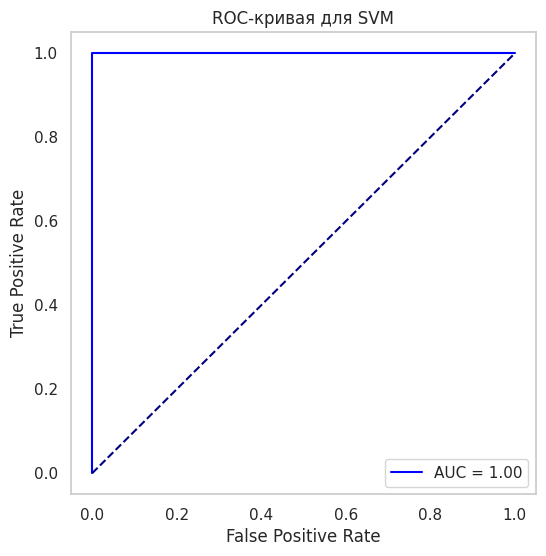

Логистическая регрессия - Матрица ошибок:
[[50  0]
 [ 0 50]]
Логистическая регрессия - Sensitivity: 1.00
Логистическая регрессия - Specificity: 1.00
Логистическая регрессия - Precision: 1.00
Логистическая регрессия - Recall: 1.00


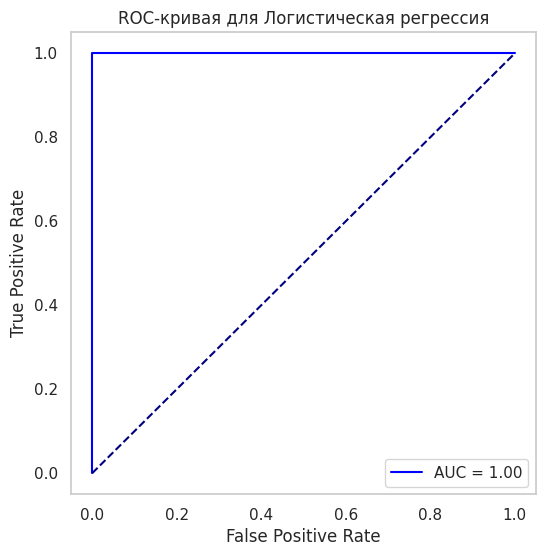

Наивный байесовский классификатор - Матрица ошибок:
[[49  1]
 [ 0 50]]
Наивный байесовский классификатор - Sensitivity: 1.00
Наивный байесовский классификатор - Specificity: 0.98
Наивный байесовский классификатор - Precision: 0.98
Наивный байесовский классификатор - Recall: 1.00


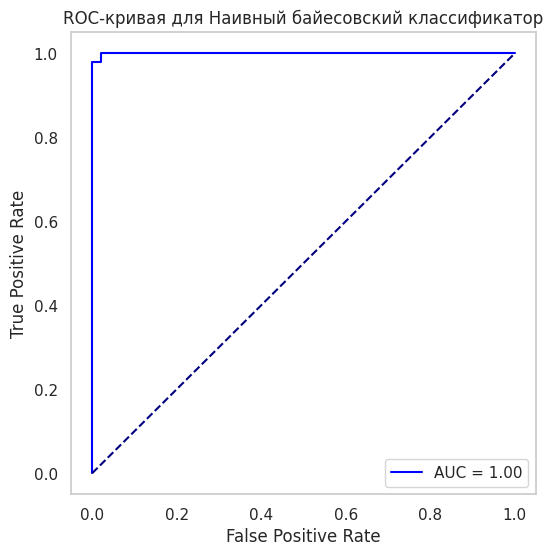

In [13]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score

def evaluate_model(clf, X, y, name):
    clf.fit(X, y)
    y_pred = clf.predict(X)
    y_proba = clf.predict_proba(X)[:, 1]  

    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)

    print(f"{name} - Матрица ошибок:\n{cm}")
    print(f"{name} - Sensitivity: {sensitivity:.2f}")
    print(f"{name} - Specificity: {specificity:.2f}")
    print(f"{name} - Precision: {precision:.2f}")
    print(f"{name} - Recall: {recall:.2f}")
    
    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='blue')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC-кривая для {name}')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


evaluate_model(lda_clf, X_selected, y_selected, "LDA")
evaluate_model(svm_clf, X_selected, y_selected, "SVM")
evaluate_model(logreg_clf, X_selected, y_selected, "Логистическая регрессия")
evaluate_model(nb_clf, X_selected, y_selected, "Наивный байесовский классификатор")
